In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("/content/drive/MyDrive/data/bank-full.csv", sep=";")

In [3]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


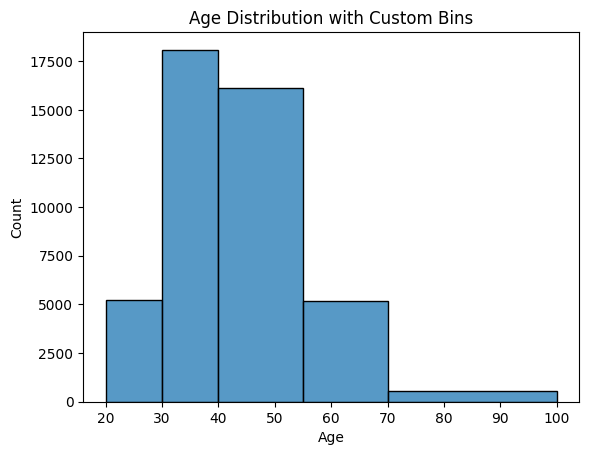

In [5]:
# Histogram with your age bins
sns.histplot(data=df, x='age', bins=[20, 30, 40, 55, 70, 100], kde=False)
plt.title("Age Distribution with Custom Bins")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [6]:
bins = [20, 35, 45, 100]
labels = ["20-35", "35-45", "45+"]

In [7]:
df['age-group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df["age-group-encoded"] = df["age-group"].astype("category").cat.codes

In [8]:
df[['age', 'age-group', 'age-group-encoded']]

,age,age-group,age-group-encoded
0,58,45+,2
1,44,35-45,1
2,33,20-35,0
3,47,45+,2
4,33,20-35,0
...,...,...,...
45206,51,45+,2
45207,71,45+,2
45208,72,45+,2
45209,57,45+,2


In [9]:
df["y"].value_counts()

,count
y,
no,39922
yes,5289


In [10]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age-group,age-group-encoded
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,45+,2
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,35-45,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,20-35,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,45+,2
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,20-35,0


In [11]:
categ = ["job", "marital", "education", "default", "housing", "loan", "month", "contact", "campaign", "poutcome"]
for cat in categ:
    df[cat] = df[cat].astype("category")

In [12]:
df["y"] = df["y"].replace({"yes":1, "no":0})

/tmp/ipython-input-479518289.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["y"] = df["y"].replace({"yes":1, "no":0})


In [13]:
X = df.drop(columns=["day", "age-group", "age-group-encoded", "job", "default", "education", "y"])

In [14]:
y = df["y"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
print("Train set distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))


Train set distribution:
y
0    0.883018
1    0.116982
Name: proportion, dtype: float64

Test set distribution:
y
0    0.883003
1    0.116997
Name: proportion, dtype: float64


In [17]:
import xgboost as xgb

In [18]:
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    eval_metric="logloss",
    # scale_pos_weight=scale_weight,
    enable_categorical = True,
    random_state=42
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [19]:
y_pred = model.predict(X_test)

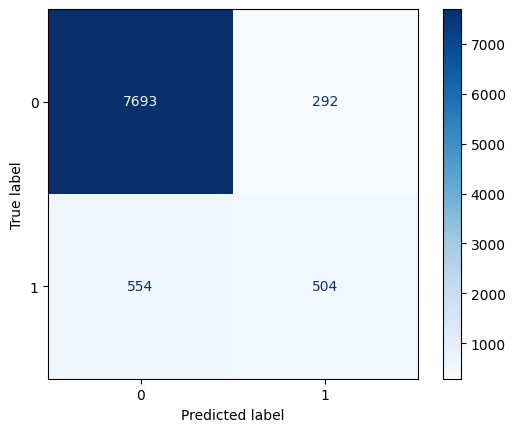

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

In [21]:
# grid search
param_gird = {
    "max_depth": [5, 7],
    "learning_rate": [0.01, 0.08, 0.1],
    "reg_lambda": [1, 1.5, 2, 2.5],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

In [22]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_gird,
    scoring="recall",
    cv=5,
    verbose=1,
    # n_jobs=-1
)

In [23]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [1.0],
                         'learning_rate': [0.01, 0.08, 0.1],
                         'max_depth': [5, 7], 'reg_lambda': [1, 1.5, 2, 2.5],
                         'subsample': [1.0]},
             scoring='recall', verbose=1)

In [24]:
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 2, 'subsample': 1.0}


In [25]:
best_model = grid_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [26]:
y_pred = best_model.predict(X_test)

In [27]:
cm = confusion_matrix(y_test, y_pred)

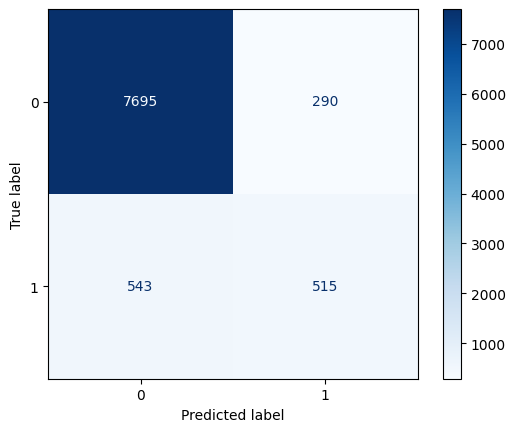

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")